# Reaction to eliminating Iranian commander by U.S. - Twitter Sentiment Analysis

**Authors:** Grzegorz Krochmal & Katarzyna Kryńska

## Goal of the project

1. Collect tweets from the period just before eliminating Iranian commander Qasem Soleimani by U.S. and after it
2. Identify how the occurences of specific words have changed in this period
3. Identify tweets' sentiment using Support Vectore Machine model

## Literature review

Emoticons are an important part of internet based language. Obviously they can tell us a lot about the sentiment of the text. In case of tweets this impact is even bigger due to the fact that the number of characters in tweets is limited, therefore use of emoticons allows users to hand on as many emotions as it is possible. Actually, there are some scientific works where potential of emoticons in area of sentiment detection is utilized for automatic annotation of tweets as positive and negative to create a huge training dataset in a short time [3].

OTHER STATS
["Content_Type", "Avg_Precision", "Avg_Recall", "Avg_F1"]

## Annotated Dataset

In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot
import re
import nltk
import datetime as dt
from nltk.corpus import stopwords 
%matplotlib inline

In [10]:
annotated_df = pd.read_csv("text_emotion.csv")
annotated_df.drop(columns = ["tweet_id", "author"], inplace = True)

For the purpose of our analysis we will use Crowdflower (The Emotion in Text dataset by CrowdFlower). It is based on 40000 manually annotated tweets, where the annotators were labeling every tweet with the most suitable emotion for it. These emotions are:

AxesSubplot(0.125,0.125;0.775x0.755)


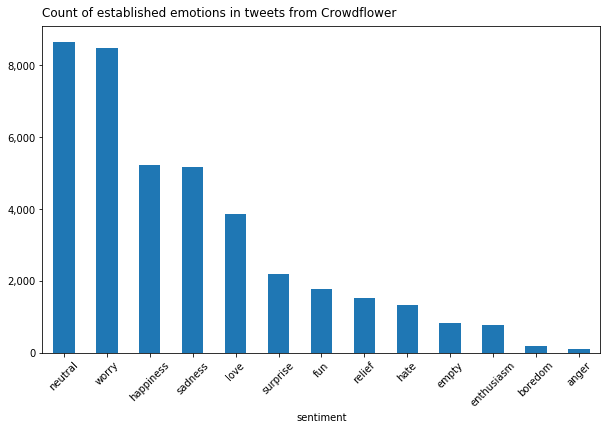

In [11]:
emotions_count = annotated_df.groupby("sentiment").count().sort_values("content", ascending = False).iloc[:,0]

plt = emotions_count.plot.bar(rot=45, color='tab:blue')
plt.set_title('Count of established emotions in tweets from Crowdflower', fontsize=12, loc="left", pad=10)
plt.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ",")))
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)
print(plt)

### Dependent Variable (sentiment) - Engineering

Some of the emotions do not seem to be significanlty different than the others. Therefore, to simplify the analysis we will use Circumplex Model of Affect [1] classify presented emotions into 4 groups. This classification has been done manually. We have tried to employ WorldNet synonyms to this task, however it did not performe well. 

The groups and the emotions bounded to it can be clearly visualised with the plot beneath (source: [2])

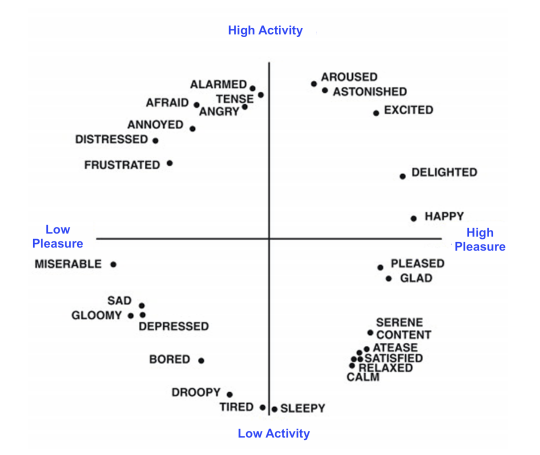

Our classification of emotions is following:

* Happy-Active: love, surprise, enthusiasm
* Happy-Inactive: happiness, relief, fun
* Unhappy-Active: worry, hate, anger
* Unhappy-Inactive: sadness, empty, boredom



In [12]:
emotions = {
    "Happy-Active":["love", "surprise", "enthusiasm"],
    "Happy-Inactive":["happiness", "relief", "fun"], 
    "Unhappy-Active":["worry", "hate", "anger"],
    "Unhappy-Inactive":["sadness", "empty", "boredom"]
}

Now let's modify our dataset so to have only 4 levels of dependent variable + neutral value which can't be classified anywhere.

AxesSubplot(0.125,0.125;0.775x0.755)


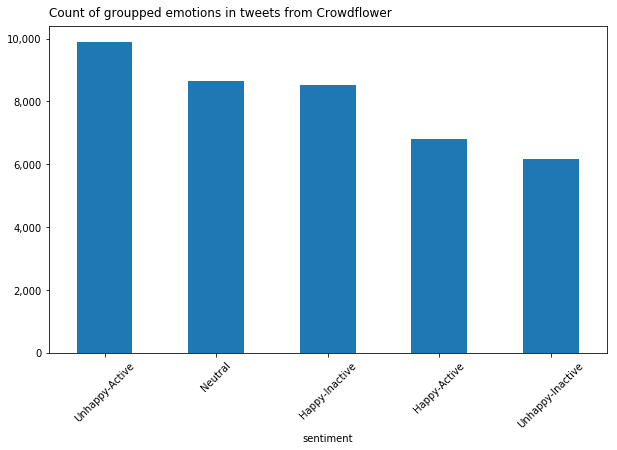

In [13]:
emotions_to_map = {}

for key in emotions.keys():
    for word in emotions[key]:
        emotions_to_map[word] = key
        
annotated_df["sentiment"] = annotated_df["sentiment"].map(emotions_to_map).fillna("Neutral")

plt = annotated_df.groupby("sentiment").count().sort_values("content", ascending = False).iloc[:,0].plot.bar(rot=45, color='tab:blue')
plt.set_title('Count of groupped emotions in tweets from Crowdflower', fontsize=12, loc="left", pad=10)
plt.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ",")))
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)
print(plt)

In [14]:
### Formatting dependent variable as category
annotated_df["sentiment"] = annotated_df["sentiment"].astype("category")

### Preparation of Tweet Content

To make tweets' content useful for our analysis we have to introduce some data preparation. First to exclude features which will not bring any valuable information to our analysis and second to make the computational process lighter. 

#### Removing @user - Name tags

In tweet one can tag other user with @user to make sure someone will notice the tweet or to reply to someone's opinion. Anyway, the name of the user itself is not a thing which will bring us better classification quality, it's not really a word feature. Therefore we will remove it.

In [16]:
def remove_tags(text):
    text = re.sub('@\w+',"", text)
    return text

#### Removing urls

Next we will exclude urls for similar reasons as in case of user tags

In [17]:
def link_remover(text):
    text = re.sub(r'http\S+',"", text)
    return text

#### Dealing with Emoticons

As it was mentioned, emoticons are an important part of internet based language. However the serious issue with the Crowdflower dataset is that it does not contain tweets in standard twitter coding (it can be check using code below). 

In [18]:
def emoji_finder(text):
    emoji_list = re.findall("[^\u0000-\uFFFF]|\u2764", text)
    
    if len(emoji_list) == 0:
        return None
    else:
        emojis = " ".join(emoji_list)
        return emojis

In [19]:
list(set(annotated_df["content"].apply(lambda text: emoji_finder(text))))

[None]

It is hard to state in what way the emoticons were actually encoded, because there is no paper regarding this matter. Therefore we decided to omit them. After all preprocessing steps it will be only words which are supposed to be left in dataset, that is why there is no need identify emoticons encoding. However, it has to be indicated that this issue is a serious limitation. 

#### Removing Hashes from Hashtags

Hashtags being in some way the topic of the tweet may carry important information, therefore we decided to keep the hashtag words but without hashtag specific "#"

In [20]:
def hashtag_extractor(text):
    text = text.replace("#", "")
    return text

#### Keeping only words

We do not expect punctuations or numbers to bring us valuable information but these are actual characters which may increase computational complexity. That is why we will keep only words

In [21]:
def keep_words_only(text):
    words_list = re.findall("\w+", text)
    return words_list

#### Removing stopwords

To simplify dataset we will also remove stopwords. To achieve this goal we will use pre-built stopowrds list from NLTK package. However it is not always obvious that removing stopwords will improve the performance of the model. The good example for this comes directly from this dataset.  

* Sentence with stopwords: We want to trade with someone who has Houston tickets
* Sentence without stopwords: We want trade someone Houston 

The first sentence is clearly a normal sentence, no one would worry about. However the second one sounds like some kind of human-trafficking advert. Having in mind that is not so difficult to thing about another similar examples where stopwords make a huge difference, we will keep also version of tweet without this step applied. 

In [25]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text, stop_words):
    text = [word for word in text if word not in stop_words]
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xx\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


#### Joined function

In [26]:
def cleaner_nostop(text):
    text = remove_tags(text)
    text = link_remover(text)
    text = hashtag_extractor(text)
    text = keep_words_only(text)
    text = remove_stopwords(text, stop_words)
    text = [word.lower() for word in text]
    
    return text

In [27]:
def cleaner_withstop(text):
    text = remove_tags(text)
    text = link_remover(text)
    text = hashtag_extractor(text)
    text = keep_words_only(text)
    text = [word.lower() for word in text]
    
    return text

In [28]:
annotated_df["Content_Cleaned_noStop"] = annotated_df["content"].apply(lambda text: cleaner_nostop(text))
annotated_df["Content_Cleaned_withStop"] = annotated_df["content"].apply(lambda text: cleaner_withstop(text))

#### Lemmatization

Having our content cleaned as the last step we will introduce lemmatization. We will produce two additional columns with lemmas. It is because however the lemmatization will limit the number of words and the computational complexity we cannot be sure that it will not decrease the quality of data and classification

In [31]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def get_lemma(text):
    text = [lemmatizer.lemmatize(word) for word in text]
    return text


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xx\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [32]:
annotated_df["Content_Cleaned_noStop_Lemma"] = annotated_df["Content_Cleaned_noStop"].apply(lambda text: get_lemma(text))
annotated_df["Content_Cleaned_withStop_Lemma"] = annotated_df["Content_Cleaned_withStop"].apply(lambda text: get_lemma(text))

Finally, let's have a look at the CrowdFlower dataset after all data preparation:

In [36]:
annotated_df.head(10)

,sentiment,content,Content_Cleaned_noStop,Content_Cleaned_withStop,Content_Cleaned_noStop_Lemma,Content_Cleaned_withStop_Lemma
0,Unhappy-Inactive,@tiffanylue i know i was listenin to bad habi...,"[know, listenin, bad, habit, earlier, started,...","[i, know, i, was, listenin, to, bad, habit, ea...","[know, listenin, bad, habit, earlier, started,...","[i, know, i, wa, listenin, to, bad, habit, ear..."
1,Unhappy-Inactive,Layin n bed with a headache ughhhh...waitin o...,"[layin, n, bed, headache, ughhhh, waitin, call]","[layin, n, bed, with, a, headache, ughhhh, wai...","[layin, n, bed, headache, ughhhh, waitin, call]","[layin, n, bed, with, a, headache, ughhhh, wai..."
2,Unhappy-Inactive,Funeral ceremony...gloomy friday...,"[funeral, ceremony, gloomy, friday]","[funeral, ceremony, gloomy, friday]","[funeral, ceremony, gloomy, friday]","[funeral, ceremony, gloomy, friday]"
3,Happy-Active,wants to hang out with friends SOON!,"[wants, hang, friends, soon]","[wants, to, hang, out, with, friends, soon]","[want, hang, friend, soon]","[want, to, hang, out, with, friend, soon]"
4,Neutral,@dannycastillo We want to trade with someone w...,"[we, want, trade, someone, houston, tickets, one]","[we, want, to, trade, with, someone, who, has,...","[we, want, trade, someone, houston, ticket, one]","[we, want, to, trade, with, someone, who, ha, ..."
5,Unhappy-Active,Re-pinging @ghostridah14: why didn't you go to...,"[re, pinging, go, prom, bc, bf, like, friends]","[re, pinging, why, didn, t, you, go, to, prom,...","[re, pinging, go, prom, bc, bf, like, friend]","[re, pinging, why, didn, t, you, go, to, prom,..."
6,Unhappy-Inactive,"I should be sleep, but im not! thinking about ...","[i, sleep, im, thinking, old, friend, i, want,...","[i, should, be, sleep, but, im, not, thinking,...","[i, sleep, im, thinking, old, friend, i, want,...","[i, should, be, sleep, but, im, not, thinking,..."
7,Unhappy-Active,Hmmm. http://www.djhero.com/ is down,[hmmm],"[hmmm, is, down]",[hmmm],"[hmmm, is, down]"
8,Unhappy-Inactive,@charviray Charlene my love. I miss you,"[charlene, love, i, miss]","[charlene, my, love, i, miss, you]","[charlene, love, i, miss]","[charlene, my, love, i, miss, you]"
9,Unhappy-Inactive,@kelcouch I'm sorry at least it's Friday?,"[i, sorry, least, friday]","[i, m, sorry, at, least, it, s, friday]","[i, sorry, least, friday]","[i, m, sorry, at, least, it, s, friday]"


## Classifier building

### SVM

As it was shown in the previous chapter, we have 4 slightly different types of tweet contents which will be used to create our model. At first we will use SVM approach which is widely used in building sentiment classifiers. We use linear kernel because after simple tests we found out that it outperforms other kernels. We use grid search with 5 fold Cross-Validation to find best parameters of C, which regulates the our margin. In this case we use unigrams as our X.  

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
cv = CountVectorizer()

train, test = train_test_split(annotated_df, test_size = 0.3, random_state = 0)

def find_best_SVM(content_type, train, test):
    
    print(content_type)
    #### Creating x and a from train and test datasets 
    train_x = train[content_type]
    train_y = train["sentiment"]

    test_x = test[content_type]
    test_y = test["sentiment"]
    
    #### Converting sets to have a format understood by vectorizer
    train_x = [" ".join(word_list) for word_list in train_x]
    test_x = [" ".join(word_list) for word_list in test_x]
    
    #### Vectorizing 
    cv.fit(train_x)
    X_train = cv.transform(train_x)
    X_test = cv.transform(test_x)
    
    print("Dimensions of train set: ", X_train.shape)
    print("Dimensions of test set: ", X_test.shape)
    
    #### Defining parameters for GridSearch
    params_grid = [{'kernel': ['linear'], 'C': [0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1]}]
    
    #### Running Model
    svm_model = GridSearchCV(SVC(), params_grid, cv = 5)
    svm_model.fit(X_train, train_y)
    
    #### Statistics
    final_model = svm_model.best_estimator_
    svm_predictions = final_model.predict(X_test)
    accuracy = final_model.score(X_test, test_y)
    accuracy_org = final_model.score(X_train, train_y)
    
    class_report = classification_report(test_y, svm_predictions, output_dict=True)
    
    return({"final_model": final_model, "accuracy": accuracy, 
            "accuracy_train": accuracy_org, "class_report": class_report})
    

In [40]:
models = {}
for content_type in list(annotated_df.columns[2:]):
    models[content_type] = find_best_SVM(content_type, train, test)

Content_Cleaned_noStop
Dimensions of train set:  (28000, 24549)
Dimensions of test set:  (12000, 24549)


KeyboardInterrupt: 

#### Results of SVM approach

After running all of the models (which took about 2.5h) we ended up knowing that in all cases the best C value = 0.1. Let's see how it has gone with other measures and which type of input brought us the best results.

##### Accuracy

In the area of accuracy we can observe that the best result for the test dataset was obtained by model based on Lemmatized words with stopwords. What has to be said is that the differences in result are really low and the performence of models, especially on Test data is rather poor - 41 % of accuracy in the best case is disappointing. 

The best case of accuracy for train data is obtained with model based on not lemmatized words with stopwords. It is equal to 55%.  

In [41]:
def accuracy(models):
    acc_list = []
    for content in models.keys():
        acc_list.append((content, models[content]["accuracy"], models[content]["accuracy_train"]))

    svm_acc_df = pd.DataFrame(acc_list, columns = ["Content_Type", "Accuracy_Test", "Accuracy_Train"])
    return(svm_acc_df.sort_values("Accuracy_Test", ascending = False))

In [42]:
accuracy(models)

,Content_Type,Accuracy_Test,Accuracy_Train


##### Other measures

In [43]:
def other_stats(models):
    other_stats = []
    for content in models.keys():
        other_stats.append([content] + list(models[content]["class_report"]["weighted avg"].values())[:-1])

    svm_oth_stats = pd.DataFrame(other_stats, columns = ["Content_Type", "Avg_Precision", "Avg_Recall", "Avg_F1"])
    return(svm_oth_stats.sort_values("Avg_Precision", ascending = False))

In [44]:
other_stats(models)

,Content_Type,Avg_Precision,Avg_Recall,Avg_F1


As it can be seen there are no special differences between presented stats of avereged values. They are all rather unsatisfactory. However some interesting observation can be made on the F1 score of sentiments for all models which is shown on the table below

In [45]:
def f1_sentiments(models):
    f1_sentiments = []
    for content in models.keys():
        f1_sentiments.append((content,
                             models[content]["class_report"]["Happy-Active"]["f1-score"],
                             models[content]["class_report"]["Happy-Inactive"]["f1-score"],
                             models[content]["class_report"]["Neutral"]["f1-score"],
                             models[content]["class_report"]["Unhappy-Active"]["f1-score"],
                             models[content]["class_report"]["Unhappy-Inactive"]["f1-score"]))

    return(pd.DataFrame(f1_sentiments, columns = ["Content_Type", "Happy-Active", "Happy-Inactive",
                                          "Neutral", "Unhappy-Active", "Unhappy-Inactive"]))

In [46]:
f1_sentiments(models)

,Content_Type,Happy-Active,Happy-Inactive,Neutral,Unhappy-Active,Unhappy-Inactive


The F1 score do not impress in all of the cases, however it is definetely the worst for 'Unhappy-Inactive' case. If other approaches will bring us similarily unsatisfactory results, we can consider grouping 'Unhappy' variables into one to increase performence of models.

### Naive-Bayes

The SVM algorithm did not perform really well on our dataset. Therefore we will try another widely used algorithm in area of sentiment analysis which is Naive-Bayes. Here we will slightly modify approach and use TF-IDF vectorizer instead of standard unigrams

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

def find_best_NaiveBayes(content, train, test):
    
    print(content)
    #### Creating x and a from train and test datasets 
    train_x = train[content_type]
    train_y = train["sentiment"]

    test_x = test[content_type]
    test_y = test["sentiment"]
    
    #### Converting sets to have a format understood by vectorizer
    train_x = [" ".join(word_list) for word_list in train_x]
    test_x = [" ".join(word_list) for word_list in test_x]
    
    # Create feature vectors
    vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             norm = "l1",
                             use_idf = True)

    X_train = vectorizer.fit_transform(train_x)
    X_test = vectorizer.transform(test_x)


    text_clf = Pipeline([('clf', MultinomialNB())])

    tuned_parameters = {
    
        'clf__alpha': [1, 1e-1, 1e-2]
    }

    bayes = GridSearchCV(text_clf, tuned_parameters, cv = 5)
    bayes.fit(X_train, train_y)
    
    best_bayes = bayes.best_estimator_
    bayes_predictions = best_bayes.predict(X_test)
    accuracy = best_bayes.score(X_test, test_y)
    accuracy_org = best_bayes.score(X_train, train_y)
    
    class_report = classification_report(test_y, bayes_predictions, output_dict=True)
    
    return({"final_model": best_bayes, "accuracy": accuracy, 
            "accuracy_train": accuracy_org, "class_report": class_report})

In [48]:
models_bayes = {}
for content_type in list(annotated_df.columns[2:]):
    models_bayes[content_type] = find_best_NaiveBayes(content_type, train, test)

Content_Cleaned_noStop
Content_Cleaned_withStop
Content_Cleaned_noStop_Lemma
Content_Cleaned_withStop_Lemma


Calculation of Naive-Bayes models were almost instant. Which is a huge difference in comparison with SVM which took more than 2 hours. Let's see how Naive-Bayes models have performed

##### Accuracy

In [49]:
accuracy(models_bayes)

,Content_Type,Accuracy_Test,Accuracy_Train
1,Content_Cleaned_withStop,0.355333,0.471143
0,Content_Cleaned_noStop,0.353500,0.441000
3,Content_Cleaned_withStop_Lemma,0.353083,0.466964
2,Content_Cleaned_noStop_Lemma,0.352583,0.438893


The performance of models, especially in area of test data, is clearly worse than in case of SVM. 

##### Other stats

In [50]:
other_stats(models_bayes)

,Content_Type,Avg_Precision,Avg_Recall,Avg_F1
0,Content_Cleaned_noStop,0.414287,0.353500,0.292981
2,Content_Cleaned_noStop_Lemma,0.407366,0.352583,0.290590
1,Content_Cleaned_withStop,0.390829,0.355333,0.301261
3,Content_Cleaned_withStop_Lemma,0.386586,0.353083,0.298502


In [51]:
f1_sentiments(models_bayes)

,Content_Type,Happy-Active,Happy-Inactive,Neutral,Unhappy-Active,Unhappy-Inactive
0,Content_Cleaned_noStop,0.182637,0.413941,0.272385,0.459633,0.021852
1,Content_Cleaned_withStop,0.203937,0.410186,0.279247,0.463154,0.041268
2,Content_Cleaned_noStop_Lemma,0.176543,0.410446,0.268892,0.461583,0.019802
3,Content_Cleaned_withStop_Lemma,0.198899,0.405373,0.278441,0.461492,0.039334


All the stats of Naive-Bayes are much worse than in case of SVM. However again we can capture pattern that F1 score fo Unhappy-Inactive class is significantly worse than other statistics. Therefore the decision has been made to group unhappy classes into one and try SVM and Bayes again.

## Models on modified CrowdFlower Dataset

In [54]:
modified_annotated_df = annotated_df.copy()
modified_annotated_df["sentiment"] = modified_annotated_df["sentiment"].apply(lambda x: "Unhappy" if x in ["Unhappy-Active", "Unhappy-Inactive"] else x)
modified_annotated_df["sentiment"] = modified_annotated_df["sentiment"].astype("category")

In [55]:
train, test = train_test_split(modified_annotated_df, test_size = 0.3, random_state = 0)

### SVM

In [56]:
models_svm_modDf = {}

for content_type in list(modified_annotated_df.columns[2:]):
    models_svm_modDf[content_type] = find_best_SVM(content_type, train, test)

Content_Cleaned_noStop
Dimensions of train set:  (28000, 24549)
Dimensions of test set:  (12000, 24549)


KeyboardInterrupt: 

In [57]:
accuracy(models_svm_modDf)

,Content_Type,Accuracy_Test,Accuracy_Train


In [58]:
other_stats(models_svm_modDf)

,Content_Type,Avg_Precision,Avg_Recall,Avg_F1


In [59]:
def f1_sentiments_mod(models):
    f1_sentiments = []
    for content in models.keys():
        f1_sentiments.append((content,
                             models[content]["class_report"]["Happy-Active"]["f1-score"],
                             models[content]["class_report"]["Happy-Inactive"]["f1-score"],
                             models[content]["class_report"]["Neutral"]["f1-score"],
                             models[content]["class_report"]["Unhappy"]["f1-score"]
                             ))

    return(pd.DataFrame(f1_sentiments, columns = ["Content_Type", "Happy-Active", "Happy-Inactive",
                                          "Neutral", "Unhappy"]))

In [60]:
f1_sentiments_mod(models_svm_modDf)

,Content_Type,Happy-Active,Happy-Inactive,Neutral,Unhappy


### Naive-Bayes

In [61]:
models_bayes_modDf = {}
for content_type in list(annotated_df.columns[2:]):
    models_bayes_modDf[content_type] = find_best_NaiveBayes(content_type, train, test)

Content_Cleaned_noStop
Content_Cleaned_withStop
Content_Cleaned_noStop_Lemma
Content_Cleaned_withStop_Lemma


In [62]:
accuracy(models_bayes_modDf)

,Content_Type,Accuracy_Test,Accuracy_Train
2,Content_Cleaned_noStop_Lemma,0.445833,0.510393
0,Content_Cleaned_noStop,0.445750,0.514607
1,Content_Cleaned_withStop,0.435833,0.480857
3,Content_Cleaned_withStop_Lemma,0.434417,0.477750


In [63]:
other_stats(models_bayes_modDf)

,Content_Type,Avg_Precision,Avg_Recall,Avg_F1
1,Content_Cleaned_withStop,0.451200,0.435833,0.319106
3,Content_Cleaned_withStop_Lemma,0.447204,0.434417,0.316414
2,Content_Cleaned_noStop_Lemma,0.443419,0.445833,0.349791
0,Content_Cleaned_noStop,0.442942,0.445750,0.350683


In [64]:
f1_sentiments_mod(models_bayes_modDf)

,Content_Type,Happy-Active,Happy-Inactive,Neutral,Unhappy
0,Content_Cleaned_noStop,0.175241,0.249786,0.119872,0.605251
1,Content_Cleaned_withStop,0.136037,0.186414,0.079338,0.598497
2,Content_Cleaned_noStop_Lemma,0.175382,0.247844,0.117042,0.605521
3,Content_Cleaned_withStop_Lemma,0.135364,0.181238,0.074560,0.597373


### Conclusion - Model Choice 

Grouping unhappy subgroups into one category brought a significant improvement for all models. However, the results still are not impresive. It is again SVM which is much more accurate and much slower than Naive-Bayes. Actually if we would compare accuracy on test data taking time into consideration it seems that Naive-Bayes might be the better choice. But if we look at accuracies on train datasets, here the supremacy of SVM is obvious. That is why SVM is our choice for further modelling. Now we only have to choose which of SVM models (and the inputs) we want to use. If we use the simplest possible measure to compare the quality of models for test and train data - average accuracy, it occurs that it is the model based on cleaned tweets without stopwords (before lemmatization). Therefore this model and this way of data cleaning is our choice for further actions.

In [65]:
df = accuracy(models_svm_modDf)
df["Average_Accuracy"] = df.apply(lambda col: (col["Accuracy_Test"] + col["Accuracy_Train"])/2, axis = 1)
df

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [ ]:
# Saving models

# import pickle
# def save_model(models, group_name):
#     for content in models.keys():
#         filename = group_name +"_" + content + ".sav"
#         pickle.dump(models[content]["final_model"], open(filename, "wb"))

# save_model(models_svm_modDf, "svm_modified")
# save_model(models, "svm_standard")
# save_model(models_bayes, "bayes_standard")
# save_model(models_bayes_modDf, "bayes_modified")

## Iran vs USA Tweet Data

In [66]:
import sqlite3
import pickle
conn = sqlite3.connect("IranianCrysis2.db")
c = conn.cursor()

In [67]:
df = pd.read_sql_query("SELECT * FROM Tweets", conn)

### Classification of tweets content

#### Data Preparation

In [68]:
df_to_classify = pd.DataFrame(df.loc[:,"tweet_text"])

In [69]:
df_to_classify["tweet_cleaned"] = df_to_classify["tweet_text"].apply(lambda text: cleaner_nostop(text))

#### Classification part

In [71]:
#### Loading best model
best_model = pickle.load(open("Models\svm_modified_Content_Cleaned_noStop.sav", 'rb'))

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC 
from sklearn.metrics import classification_report
cv = CountVectorizer()
#### Loading data to train the model (now the whole set)
train_data = modified_annotated_df.loc[:,["sentiment", "Content_Cleaned_noStop"]]
train_x = train_data["Content_Cleaned_noStop"]
train_x = [" ".join(word_list) for word_list in train_x]
train_y = train_data["sentiment"]

#### Loading data to be fitted
X_to_fit = df_to_classify["tweet_cleaned"]
X_to_fit = [" ".join(word_list) for word_list in X_to_fit]

#### Vectorizing 
cv.fit(train_x)
X_train = cv.transform(train_x)
X_to_fit_vectorized = cv.transform(X_to_fit)

print("Dimensions of train set: ", X_train.shape)
print("Dimensions of to be fitted set: ", X_to_fit_vectorized.shape)

model = best_model.fit(X_train, train_y)
sentiment_predictions = model.predict(X_to_fit_vectorized)

Dimensions of train set:  (40000, 30241)
Dimensions of to be fitted set:  (465080, 30241)


KeyboardInterrupt: 

In [ ]:
df["Sentiment_Predictions"] = sentiment_predictions

In [ ]:
df.drop(columns = ["hashtag_search"], inplace = True)

In [ ]:
df.to_sql("Tweets_with_Sentiment", conn)

#### Results

In [73]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("IranianCrysis2.db")
c = conn.cursor()
df = pd.read_sql_query("SELECT * FROM Tweets_with_Sentiment", conn)

AxesSubplot(0.125,0.125;0.775x0.755)


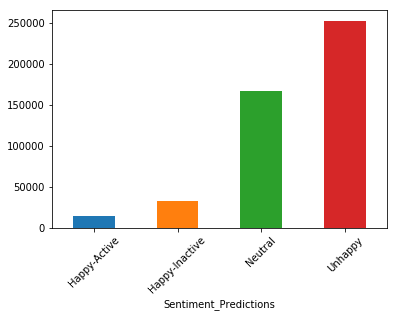

In [75]:
print(df.groupby("Sentiment_Predictions").count().loc[:,"tweet_text"].plot.bar(rot=45))

Tweet sentiments grouped by time

In [76]:
df

,index,generated_id,tweet_createdAt,tweet_id,tweet_userID,tweet_text,Sentiment_Predictions
0,0,1.0,2020-01-04 23:59:57,1213611053210382337,1001775960763588608,People voted Tory to get #Brexit and ended up ...,Unhappy
1,1,2.0,2020-01-04 23:59:57,1213611051306160129,2843218126,Memes about an impending third World War went ...,Unhappy
2,2,3.0,2020-01-04 23:59:56,1213611050496659456,3196345114,"It is happening in #Scotland, #England, #NornI...",Neutral
3,3,4.0,2020-01-04 23:59:50,1213611025272049670,101193997,@BernardKerik @realclearisrael The current #Ir...,Unhappy
4,4,5.0,2020-01-04 23:59:49,1213611018716418048,481366248,Liverpool cruising to the League title... thei...,Happy-Active
5,5,6.0,2020-01-04 23:59:47,1213611011799965697,1138224043646214144,@Kaepernick7 You wouldn’t know the first thing...,Neutral
6,6,7.0,2020-01-04 23:59:47,1213611009270792192,602763611,Charging the field in #WWIII #ww3memes https:/...,Unhappy
7,7,8.0,2020-01-04 23:59:45,1213611002106798080,1181314578,@ericbolling @IlhanMN And no doubt used #Obama...,Unhappy
8,8,9.0,2020-01-04 23:59:44,1213611000517267456,1152180563178115072,Stuff up it their ass. The sooner the better. ...,Unhappy
9,9,10.0,2020-01-04 23:59:43,1213610994217435137,1188490166698156032,#Fight_Your_War_Outside_Our_Land 🇮🇶🇮🇶 \nI Mean...,Unhappy


In [82]:
df['tweet_createdAt'] = pd.to_datetime(df['tweet_createdAt'])

In [200]:
df5 = df.groupby([pd.Grouper(key='tweet_createdAt',freq='H'),pd.Grouper('Sentiment_Predictions')])['Sentiment_Predictions'].count().unstack().fillna(0)

In [206]:
df5

Sentiment_Predictions,Unhappy,Neutral,Happy-Active,Happy-Inactive
tweet_createdAt,,,,
2019-12-28 21:00:00,59,42,3,11
2019-12-28 22:00:00,98,101,7,15
2019-12-28 23:00:00,116,96,15,20
2019-12-29 00:00:00,99,79,12,14
2019-12-29 01:00:00,93,95,8,17
2019-12-29 02:00:00,117,115,16,26
2019-12-29 03:00:00,198,149,27,28
2019-12-29 04:00:00,145,147,20,24
2019-12-29 05:00:00,186,132,10,26


In [187]:
df.set_index('tweet_createdAt')['Sentiment_Predictions'].groupby(pd.Grouper(freq='H'),pd.Grouper('Sentiment_Predictions')).count()

ValueError: No axis named Grouper(key='Sentiment_Predictions', axis=0, sort=False) for object type <class 'pandas.core.series.Series'>

In [197]:
df2 = df.groupby([df['tweet_createdAt'].dt.date])['Sentiment_Predictions'].value_counts().unstack().fillna(0)
df2
#df2['Total_num_of_tweets'] = df2.sum(axis=1)

Sentiment_Predictions,Happy-Active,Happy-Inactive,Neutral,Unhappy
tweet_createdAt,,,,
2019-12-28,25,46,239,273
2019-12-29,466,831,4832,5257
2019-12-30,513,1040,5509,5492
2019-12-31,708,1625,7394,9420
2020-01-01,591,1465,5162,5720
2020-01-02,460,1060,5620,6030
2020-01-03,5829,15090,73610,123675
2020-01-04,2587,5851,32046,49179
2020-01-05,1093,2171,14133,21372


AxesSubplot(0.125,0.2;0.775x0.68)


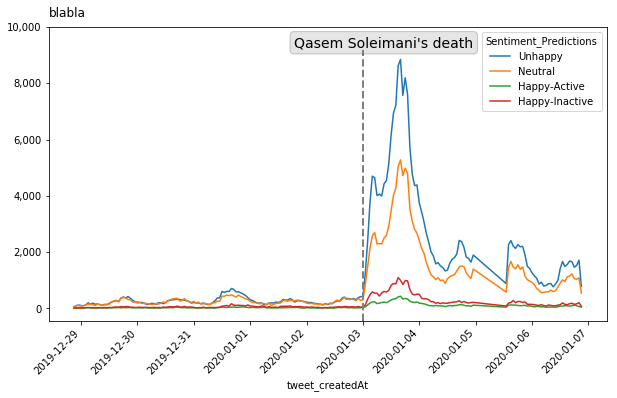

In [205]:
plt = df5.plot(rot=45)
plt.set_title('blabla', fontsize=12, loc="left", pad=10)
plt.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ",")))
plt.set_ylim(top=10000)
plt.axvline(dt.datetime(2020, 1, 3),linewidth=2, color='gray', ymax=0.92, linestyle="--")
plt.text(0.44, 0.97, "Qasem Soleimani's death", transform=plt.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(alpha=0.2,boxstyle='round',facecolor='gray'))
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)
print(plt)

AxesSubplot(0.125,0.125;0.775x0.755)


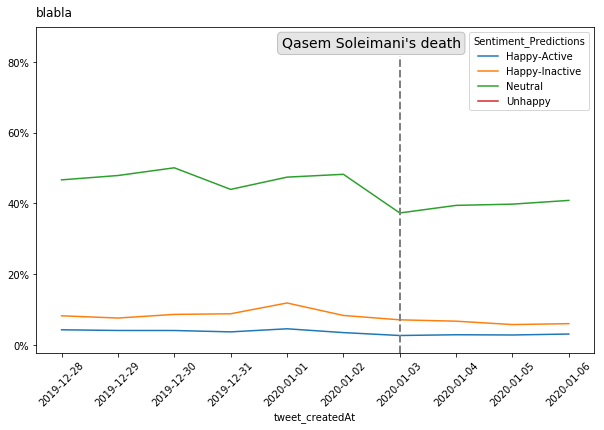

In [207]:
df3 = df2.copy()
for column in df3.columns:
    df3[column] = df3[column] / df3.sum(axis=1)
plt = df3.plot(rot=45)
plt.set_title('blabla', fontsize=12, loc="left", pad=10)
plt.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
plt.set_ylim(top=0.9)
plt.axvline(dt.datetime(2020, 1, 3),linewidth=2, color='gray', ymax=0.91, linestyle="--")
plt.text(0.44, 0.97, "Qasem Soleimani's death", transform=plt.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(alpha=0.2,boxstyle='round',facecolor='gray'))
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)
print(plt)

In [209]:
df5.head(5)

Sentiment_Predictions,Unhappy,Neutral,Happy-Active,Happy-Inactive
tweet_createdAt,,,,
2019-12-28 21:00:00,59,42,3,11
2019-12-28 22:00:00,98,101,7,15
2019-12-28 23:00:00,116,96,15,20
2019-12-29 00:00:00,99,79,12,14
2019-12-29 01:00:00,93,95,8,17


In [213]:
df3 = df5.copy()
df3.sum(axis=1).head(5)

tweet_createdAt
2019-12-28 21:00:00    115
2019-12-28 22:00:00    221
2019-12-28 23:00:00    247
2019-12-29 00:00:00    204
2019-12-29 01:00:00    213
dtype: int64

In [220]:
df3 = df5.copy()
total_sum = df3.sum(axis=1)
for column in df3.columns:
    df3[column] = df3[column] / total_sum
df3

Sentiment_Predictions,Unhappy,Neutral,Happy-Active,Happy-Inactive
tweet_createdAt,,,,
2019-12-28 21:00:00,0.513043,0.365217,0.026087,0.095652
2019-12-28 22:00:00,0.443439,0.457014,0.031674,0.067873
2019-12-28 23:00:00,0.469636,0.388664,0.060729,0.080972
2019-12-29 00:00:00,0.485294,0.387255,0.058824,0.068627
2019-12-29 01:00:00,0.436620,0.446009,0.037559,0.079812
2019-12-29 02:00:00,0.427007,0.419708,0.058394,0.094891
2019-12-29 03:00:00,0.492537,0.370647,0.067164,0.069652
2019-12-29 04:00:00,0.431548,0.437500,0.059524,0.071429
2019-12-29 05:00:00,0.525424,0.372881,0.028249,0.073446


AxesSubplot(0.125,0.2;0.775x0.68)


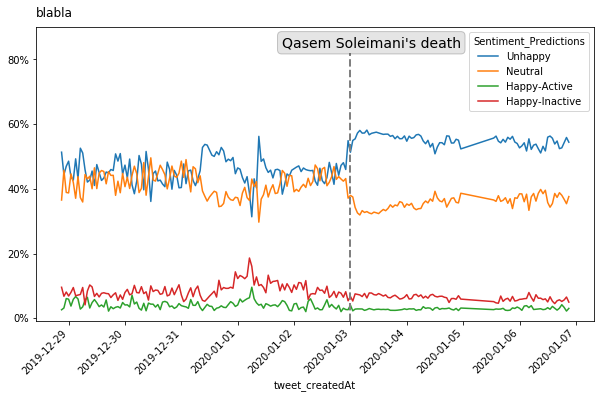

In [221]:
df3 = df5.copy()
total_num_of_tweets = df3.sum(axis=1)
for column in df3.columns:
    df3[column] = df3[column] / total_num_of_tweets
plt = df3.plot(rot=45)
plt.set_title('blabla', fontsize=12, loc="left", pad=10)
plt.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
plt.set_ylim(top=0.9)
plt.axvline(dt.datetime(2020, 1, 3),linewidth=2, color='gray', ymax=0.91, linestyle="--")
plt.text(0.44, 0.97, "Qasem Soleimani's death", transform=plt.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(alpha=0.2,boxstyle='round',facecolor='gray'))
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)
print(plt)

## Bibliography

[1]: Russell, J. A. (1980). "A circumplex model of affect". Journal of Personality and Social Psychology, vol. 39, pp. 1161– 1178.

[2]: Hasan, M., Rundensteiner, E., & Agu, Emmanuel. (2014). "EMOTEX: Detecting Emotions in Twitter Messages". Computer Science Department, Worcester Polytechnic Institute

[3] Go, A., Bhayani, R., & Huang, L. (2009). "Twitter sentiment classification using distant supervision". CS224N Project Report, Stanford

